Preprocessing 

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


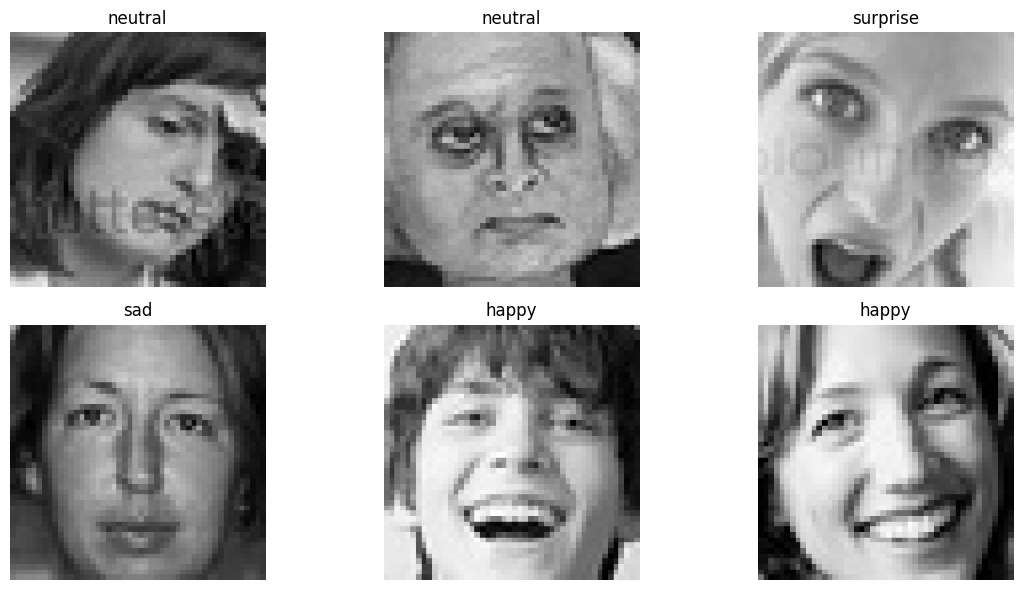

In [22]:
# 1. Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm.notebook import tqdm
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io, color
import pandas as pd

# 2. Define Paths
train_dir = '/workspaces/Emotion_detector/Data/images/images/train'         # Adjust path if needed
val_dir = '/workspaces/Emotion_detector/Data/images/images/validation'
processed_root = '/workspaces/Emotion_detector/Data/Maheshi/processed_images'

# Create processed directories
os.makedirs(processed_root, exist_ok=True)

# 3. Image Settings for ResNet
img_size = (224, 224)                 # ResNet input size
batch_size = 32

# 4. Data Generators (Normalize RGB)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# 5. Load Training Data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='rgb',                 # ResNet needs RGB
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# 6. Load Validation Data
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# 7. Check Class Indices
print("Class labels:", train_data.class_indices)

# 8. Visualize Sample Images
images, labels = next(train_data)
class_names = list(train_data.class_indices.keys())

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"{class_names[np.argmax(labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [23]:
def analyze_image_quality(image_path):
    """
    Analyze image quality and return issues if any.
    Returns: (is_valid, issue_description)
    """
    try:
        img = Image.open(image_path)
        img_array = np.array(img)
        
        # Check if image is pitchblack (all pixels very dark)
        if np.mean(img_array) < 10:
            return False, "Pitchblack image"
        
        # Check if image is too bright/washed out
        if np.mean(img_array) > 245:
            return False, "Too bright"
        
        # Accept images as small as 48x48
        if img.size[0] < 48 or img.size[1] < 48:
            return False, "Too small"
        
        return True, "OK"
    except Exception as e:
        return False, f"Error: {str(e)}"

# Analyze all images and collect statistics
image_quality_data = []
for split in ['train', 'validation']:
    base_dir = train_dir if split == 'train' else val_dir
    for emotion in os.listdir(base_dir):
        emotion_dir = os.path.join(base_dir, emotion)
        if not os.path.isdir(emotion_dir):
            continue
            
        for img_name in tqdm(os.listdir(emotion_dir), desc=f"{split}-{emotion}"):
            if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
                
            img_path = os.path.join(emotion_dir, img_name)
            is_valid, issue = analyze_image_quality(img_path)
            
            image_quality_data.append({
                'split': split,
                'emotion': emotion,
                'image': img_name,
                'is_valid': is_valid,
                'issue': issue
            })

# Convert to DataFrame for analysis
quality_df = pd.DataFrame(image_quality_data)

# Display summary statistics
print("\nImage Quality Summary:")
print("-" * 50)
print(f"Total images analyzed: {len(quality_df)}")
print(f"Valid images: {sum(quality_df['is_valid'])}")
print(f"Invalid images: {sum(~quality_df['is_valid'])}")
print("\nIssues breakdown:")
print(quality_df[~quality_df['is_valid']]['issue'].value_counts())

train-angry:   0%|          | 0/3993 [00:00<?, ?it/s]

train-disgust:   0%|          | 0/436 [00:00<?, ?it/s]

train-fear:   0%|          | 0/4103 [00:00<?, ?it/s]

train-happy:   0%|          | 0/7164 [00:00<?, ?it/s]

train-neutral:   0%|          | 0/4982 [00:00<?, ?it/s]

train-sad:   0%|          | 0/4938 [00:00<?, ?it/s]

train-surprise:   0%|          | 0/3205 [00:00<?, ?it/s]

validation-angry:   0%|          | 0/960 [00:00<?, ?it/s]

validation-disgust:   0%|          | 0/111 [00:00<?, ?it/s]

validation-fear:   0%|          | 0/1018 [00:00<?, ?it/s]

validation-happy:   0%|          | 0/1825 [00:00<?, ?it/s]

validation-neutral:   0%|          | 0/1216 [00:00<?, ?it/s]

validation-sad:   0%|          | 0/1139 [00:00<?, ?it/s]

validation-surprise:   0%|          | 0/797 [00:00<?, ?it/s]


Image Quality Summary:
--------------------------------------------------
Total images analyzed: 35887
Valid images: 35868
Invalid images: 19

Issues breakdown:
issue
Pitchblack image    15
Too bright           4
Name: count, dtype: int64


<Figure size 1500x600 with 0 Axes>

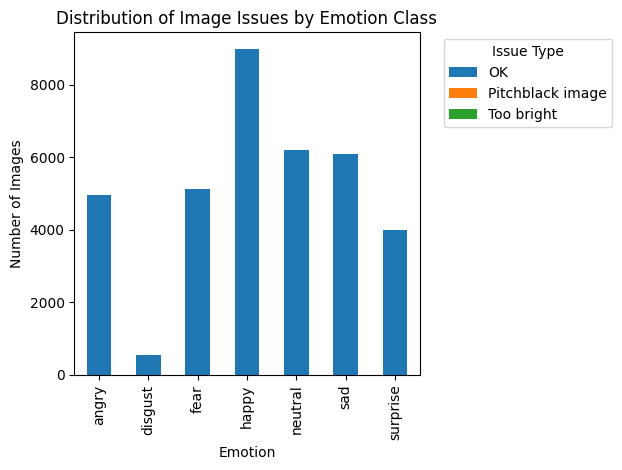


Examples of Pitchblack image images:


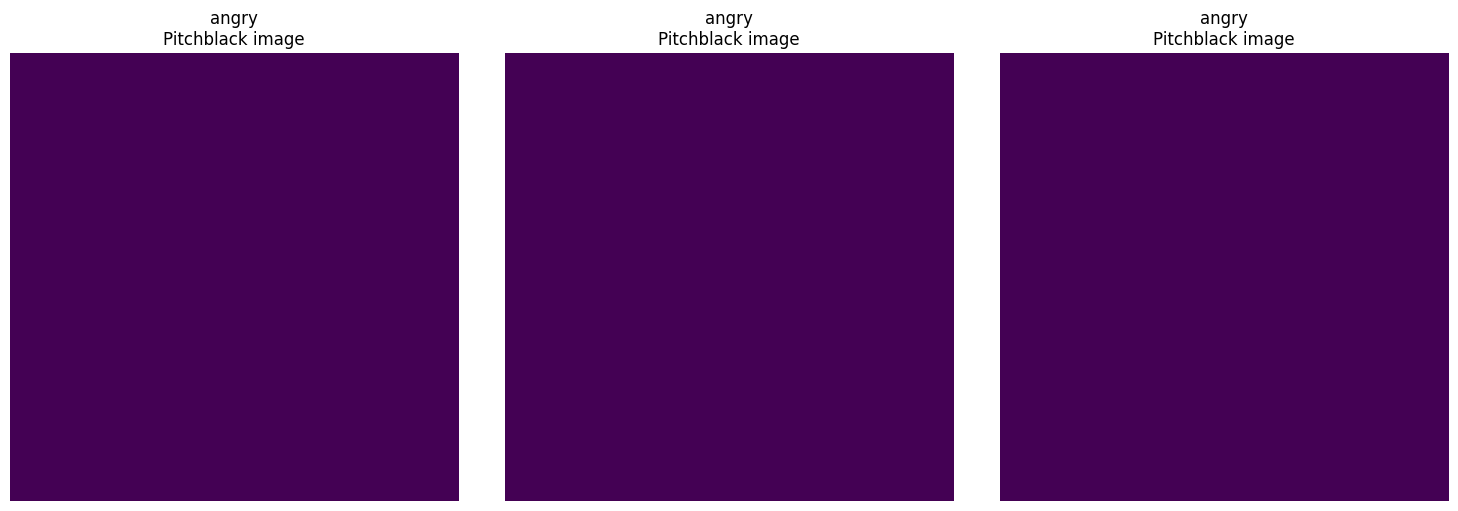


Examples of Too bright images:


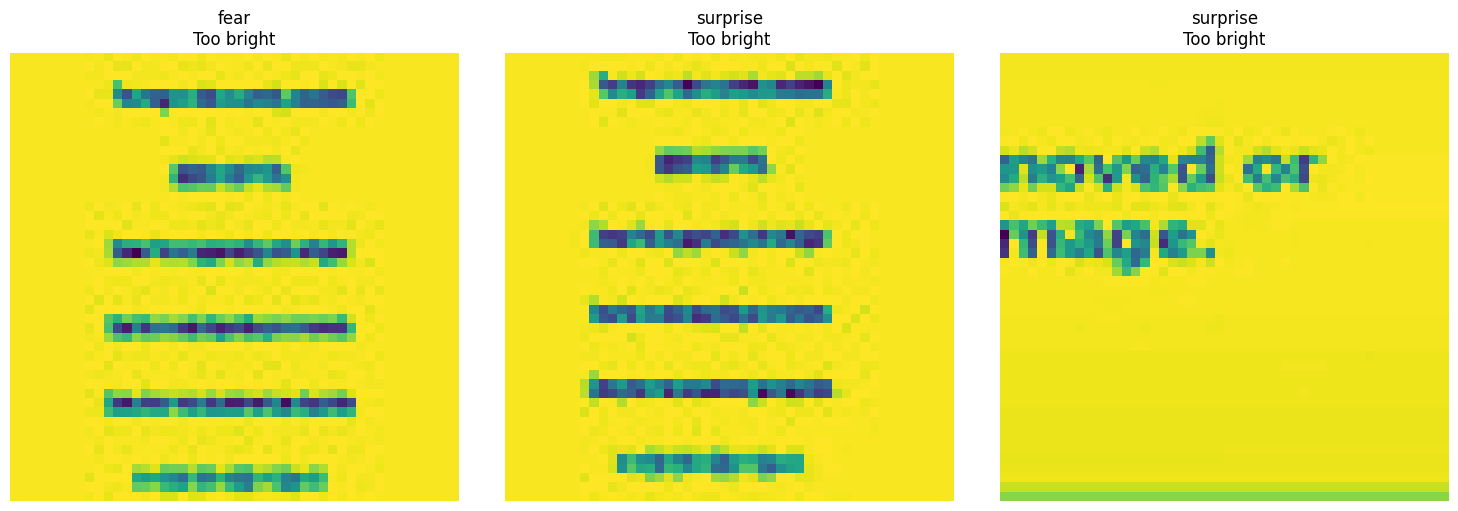

In [24]:
# Visualize distribution of issues by emotion class
plt.figure(figsize=(15, 6))
issue_by_emotion = pd.crosstab(quality_df['emotion'], quality_df['issue'])
issue_by_emotion.plot(kind='bar', stacked=True)
plt.title('Distribution of Image Issues by Emotion Class')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.legend(title='Issue Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Display examples of problematic images
def show_problem_examples(quality_df, issue_type, num_examples=3):
    problem_images = quality_df[quality_df['issue'] == issue_type]
    if len(problem_images) == 0:
        print(f"No images found with issue: {issue_type}")
        return
        
    plt.figure(figsize=(15, 5))
    for i in range(min(num_examples, len(problem_images))):
        img_info = problem_images.iloc[i]
        img_path = os.path.join(
            train_dir if img_info['split'] == 'train' else val_dir,
            img_info['emotion'],
            img_info['image']
        )
        
        plt.subplot(1, num_examples, i + 1)
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f"{img_info['emotion']}\n{issue_type}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show examples for each type of issue
for issue_type in quality_df[~quality_df['is_valid']]['issue'].unique():
    print(f"\nExamples of {issue_type} images:")
    show_problem_examples(quality_df, issue_type)

In [25]:
# Function to preprocess and save valid images
def preprocess_and_save_valid_images(quality_df, processed_root):
    """
    Preprocess and save only the valid images to the new location.
    """
    valid_images = quality_df[quality_df['is_valid']]
    
    for split in ['train', 'validation']:
        split_data = valid_images[valid_images['split'] == split]
        
        for emotion in split_data['emotion'].unique():
            # Create emotion directory in processed folder
            save_dir = os.path.join(processed_root, split, emotion)
            os.makedirs(save_dir, exist_ok=True)
            
            # Get valid images for this emotion
            emotion_images = split_data[split_data['emotion'] == emotion]
            
            for _, row in tqdm(emotion_images.iterrows(), 
                             desc=f"Processing {split}-{emotion}",
                             total=len(emotion_images)):
                
                # Source image path
                src_path = os.path.join(
                    train_dir if split == 'train' else val_dir,
                    emotion,
                    row['image']
                )
                
                # Destination path
                dst_path = os.path.join(save_dir, row['image'])
                
                try:
                    # Read, resize, and save image
                    img = Image.open(src_path)
                    img = img.convert('RGB')  # Ensure RGB
                    img = img.resize(img_size)
                    img.save(dst_path, quality=95)  # High quality JPEG
                except Exception as e:
                    print(f"Error processing {src_path}: {e}")

# Process and save valid images
print("Processing and saving valid images...")
preprocess_and_save_valid_images(quality_df, processed_root)
print("\nPreprocessing complete! Processed images saved to:", processed_root)

# Print final statistics
for split in ['train', 'validation']:
    print(f"\n{split.capitalize()} set statistics:")
    split_total = sum(1 for _ in os.walk(os.path.join(processed_root, split)))

Processing and saving valid images...


Processing train-angry:   0%|          | 0/3987 [00:00<?, ?it/s]

Processing train-disgust:   0%|          | 0/436 [00:00<?, ?it/s]

Processing train-fear:   0%|          | 0/4102 [00:00<?, ?it/s]

Processing train-happy:   0%|          | 0/7161 [00:00<?, ?it/s]

Processing train-neutral:   0%|          | 0/4981 [00:00<?, ?it/s]

Processing train-sad:   0%|          | 0/4938 [00:00<?, ?it/s]

Processing train-surprise:   0%|          | 0/3201 [00:00<?, ?it/s]

Processing validation-angry:   0%|          | 0/957 [00:00<?, ?it/s]

Processing validation-disgust:   0%|          | 0/111 [00:00<?, ?it/s]

Processing validation-fear:   0%|          | 0/1018 [00:00<?, ?it/s]

Processing validation-happy:   0%|          | 0/1825 [00:00<?, ?it/s]

Processing validation-neutral:   0%|          | 0/1216 [00:00<?, ?it/s]

Processing validation-sad:   0%|          | 0/1138 [00:00<?, ?it/s]

Processing validation-surprise:   0%|          | 0/797 [00:00<?, ?it/s]


Preprocessing complete! Processed images saved to: /workspaces/Emotion_detector/Data/Maheshi/processed_images

Train set statistics:

Validation set statistics:


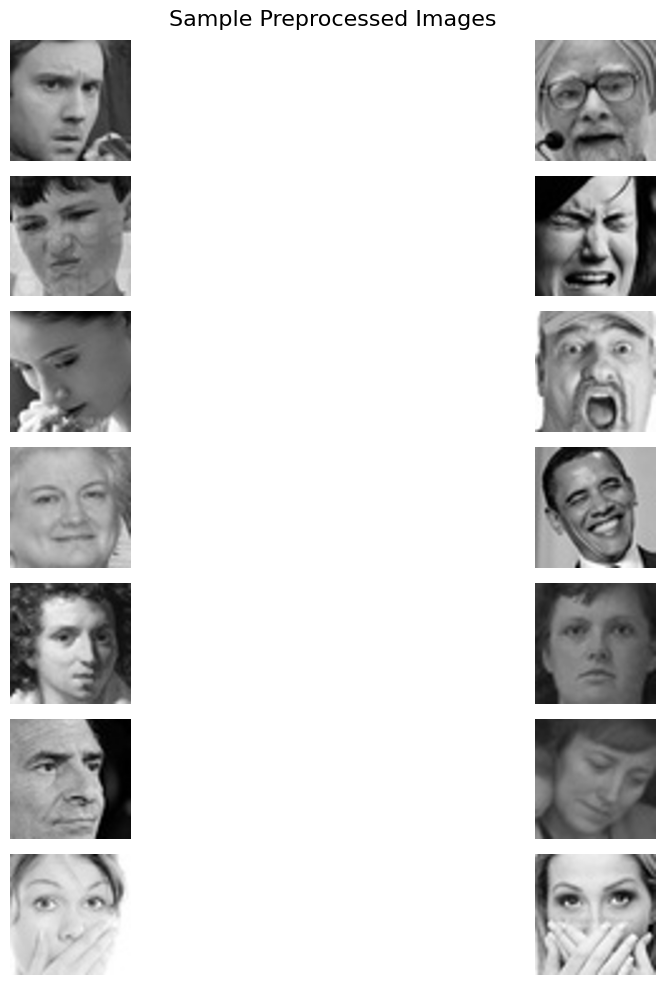

In [26]:
# Visualize sample preprocessed images
def show_preprocessed_samples(processed_root, num_per_class=2):
    plt.figure(figsize=(15, 10))
    classes = sorted(os.listdir(os.path.join(processed_root, 'train')))
    
    for i, emotion in enumerate(classes):
        class_path = os.path.join(processed_root, 'train', emotion)
        images = os.listdir(class_path)[:num_per_class]
        
        for j, img_name in enumerate(images):
            plt.subplot(len(classes), num_per_class, i*num_per_class + j + 1)
            img = plt.imread(os.path.join(class_path, img_name))
            plt.imshow(img)
            if j == 0:
                plt.ylabel(emotion)
            plt.axis('off')
    
    plt.suptitle('Sample Preprocessed Images', fontsize=16)
    plt.tight_layout()
    plt.show()

show_preprocessed_samples(processed_root)